# makemore: part 3

### Creating the dataset and i2s <-> s2i

In [ ]:
# Import libraries 
import math 
import random
import torch
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt         # for making figures
%matplotlib inline
from typing import Union, Dict, Tuple, List, Any 
from IPython.display import clear_output

In [ ]:
# Here we will import the list with all the words/names 
import os 
words_txt_file_path = os.path.join(os.path.expanduser("~"), "NN_zero_to_hero", "Lectures", "Makemore_repo", "names.txt")
words = open(words_txt_file_path, 'r').read().splitlines()

print(f"Now we have read the {len(words)} words from the file. Here we display the first 8 words\n{words[:8]}")

In [ ]:
### Here we are building the vocabulary and mapping from char to integer and vice versa 
chars = sorted(list(set(''.join(words))))           # Read all unique characters in all words 
s_to_i = {s:i+1 for i,s in enumerate(chars)}        # Create a mapping from char to index integer
s_to_i['.'] = 0                                     # Assign the index of our special start/end token '.' to 0
i_to_s = {i:s for s,i in s_to_i.items()}            # Reverse the mapping from integer to char 
num_classes = len(s_to_i)                           # Read the different number of characters available in our dataset 
vocab_size = num_classes                            # Vocabulary = number of different tokens available for the model 

print(f"Now we have created the mappings between chars and integers and vice versa, which yields to {num_classes} different, possible characters (i.e. classes) in our dataset:\n{s_to_i=}\n{i_to_s=}")

In [ ]:
### Build the dataset

# Create the dataset arrays from the words list
def build_dataset(words, s2i: Dict = s_to_i, block_size: int = 3, num_words: Union[int, None] = None, ):  
  X, Y = [], []
  for w in (words if num_words is None else words[:num_words] if isinstance(words[:num_words], list) else [words[:num_words]]): 
    context = [0] * block_size
    for ch in w + '.':
      ix = s2i[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]                              # crop and append the next character to the context
  return torch.tensor(X), torch.tensor(Y)


# Print metadata 
random.seed(42)                                                 # Choose a seed for deterministic shuffling 
random.shuffle(words)                                           # inplace shuffling of the words list 
n1 = int(0.8*len(words))                                        # Extract an integer for the 80% of the dataset 
n2 = int(0.9*len(words))                                        # Extract an integer for the 90% of the dataset 

block_size = 3                                                  # context length: how many characters do we take to predict the next one?
Xtr,  Ytr  = build_dataset(words[:n1], block_size=block_size)   # Build the training split 
Xdev, Ydev = build_dataset(words[n1:n2], block_size=block_size) # Build the validation (dev) split 
Xte,  Yte  = build_dataset(words[n2:], block_size=block_size)   # Build the test split 


### MLP revisited

##### Functions for generating model parameters and training the model

In [ ]:
##### Generate parameters function 

# Generate the parameters of the model 
def generate_parameters(random_seed: int = 2147483646, emb_dim: int = 2, num_hidden_neurons: int = 100, block_size: int = 3, num_classes: int = num_classes, 
                        return_generator: bool = False, emb_scale: float = 1.0, W1_scale: float = 1.0, W2_scale: float = 1.0, b1_scale: float = 1.0, b2_scale: float = 1.0,
                        emb_offset: float = 0.0, W1_offset: float = 0.0, W2_offset: float = 0.0, b1_offset: float = 0.0, b2_offset: float = 0.0, use_BN: bool = True) -> Tuple[torch.tensor]:
    g = torch.Generator().manual_seed(random_seed)          # for reproducibility and deterministic generation 
    
    # Create all the layers and trainable parameters. Scale them according to the chosen hyperparameters parameters
    C = torch.randn((num_classes, emb_dim), generator=g) * emb_scale + emb_offset
    W1 = torch.randn((emb_dim*block_size, num_hidden_neurons), generator=g) * W1_scale + W1_offset 
    b1 = torch.randn(num_hidden_neurons, generator=g) * b1_scale + b1_offset 
    W2 = torch.randn((num_hidden_neurons, num_classes), generator=g) * W2_scale + W2_offset 
    b2 = torch.randn(num_classes, generator=g) * b2_scale + b2_offset 

    # BatchNorm parameters. We want our layers to be approx gaussian, hence bias (offset) will be initialized to be zeros and standard deviation (spred) will be initialized to be one 
    bn_gain = torch.ones((1, num_hidden_neurons))                       # Initiate the running gain to be ones
    bn_bias = torch.zeros((1, num_hidden_neurons))                      # Initiate the running bias to be zeros 
    bn_mean_running = torch.zeros((1, num_hidden_neurons))              # Initiate the running mean to be zeros 
    bn_std_running = torch.ones((1, num_hidden_neurons))                # Initiate the running std to be ones 

    # Assure all parameters have set "required_grad" to True and return the parameters 
    for p in [C, W1, b1, W2, b2, bn_gain, bn_bias]:
        p.requires_grad = True
    
    return C, W1, b1, W2, b2, bn_gain, bn_bias, bn_mean_running, bn_std_running, g


# Compute the total number of parameters in our network 
C, W1, b1, W2, b2, bn_gain, bn_bias, bn_mean_running, bn_std_running, g = generate_parameters()
parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
num_parameters = sum(p.nelement() for p in parameters)          # number of parameters in total
print(f"This means that with the embedding dimension {C.shape[1]} and a two layer MLP with {W1.shape[1]} in each layer, we end up at {num_parameters} trainable parameters")

In [ ]:
##### Define the training function

"""
This we will use to both showcase some different examples:
1) How do we correct the initial loss when training? 
    By lowering the actual sizes of the weight parameters to the loss function which produces the logits, i.e. by lowering the weights of W2
2) How do we avoid saturation of the tanh activation function?
    By lowering the input values to the tanh, by lowering the weight parameters of the W1 layer
3) 
"""



def train_func(inp_data: torch.tensor, targets: torch.tensor, emb_matrix: torch.tensor = C, batch_size: int = 32, num_iterations: int = 20,
        lr_scheduler: Union[torch.tensor, None] = None, lr: Union[torch.tensor, None] = 1e-4, use_batch_norm: bool = False, **kwargs) -> Tuple[List, List, List, List]:
    # Initiating lists to store the data that we want to keep 
    lri = []
    lossi = []
    stepi = []

    # Regenerate the parameters of the network at random state 
    C, W1, b1, W2, b2, bn_gain, bn_bias, bn_mean_running, bn_std_running, g = generate_parameters(return_generator=True, use_BN=use_batch_norm, **kwargs)
    parameters = [emb_matrix, W1, b1, W2, b2]
    if use_batch_norm:
        parameters.extend([bn_gain, bn_bias]) 

    # Iterating through all the selected iterations 
    if lr_scheduler is None:
        lr_scheduler = torch.full((num_iterations,), lr)                        # Repeat the provided learning rate for all iterations 
    for i in range(num_iterations):
        ### Forward pass 
        # Create a single mini batch from the dataset 
        idx = torch.randint(0, inp_data.shape[0], (batch_size,), generator=g)   # Create integer index array for creating stochastic mini-batches 
        emb = emb_matrix[inp_data[idx]]                                         # (32, 3, 2) --> Read the embedding vectors of the randomly selected examples for the current iteration 
        emb_cat = emb.view(-1, emb.shape[1]*emb.shape[2])                       # Concatenate the last 'block_size' characters together in an array of sequences 

        # Linear layer 
        h_pre_act_func = emb_cat @ W1                                           # (32, 100)   --> Compute the output of the first hidden layer of our MLP model, without using the bias 
        
        # BatchNorm layer
        if use_batch_norm:
            bn_mean_i = h_pre_act_func.mean(0, keepdim=True) 
            bn_std_i = h_pre_act_func.std(0, keepdim=True)
            h_pre_act_func = bn_gain * (h_pre_act_func-bn_mean_i) / bn_std_i + bn_bias 

            # Updating the running mean and running standard deviation of the entire dataset
            # We are keeping track of these mean and standard deviation values during training,
            # so we don't need to compute them afterwards 
            with torch.no_grad():
                bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i   # Running mean of the batches in the dataset 
                bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i      # Running standard deviation of the batches in the dataset 
        else:
            h_pre_act_func += b1                                                # (32, 100)   --> Add the bias to the output of the first hidden layer, if we are not using batch normalization 
        
        # Non-linearity 
        h_act_func = torch.tanh(h_pre_act_func)                                 # (32, 100)   --> Compute the
        logits = h_act_func @ W2 + b2                                           # (32, 27)    --> Compute the logits of the forward pass 
        loss = F.cross_entropy(logits, targets[idx])                            # Compute the NLL loss (equal to the cross entropy) using the efficient pytorch implementation 
                
        ### Backward pass 
        # According to Karparthy, setting the gradient to None is more efficient than p.grad = 0, when using PyTorch .backward() method 
        for p in parameters:
            p.grad = None
        loss.backward()                                 # Compute the new gradients for all parameters 

        ### Update all the parameters 
        # If the we are using batch norm, the bias unit for the first layer, i.e. the tensor b1, will not have any gradients, hence b1.grad==None 
        lr = lr_scheduler[i]
        for idx, p in enumerate(parameters):
            if p.grad is not None:
                p.data += -lr * p.grad 
        
        # Track the stats
        lri.append(lr)
        stepi.append(i)
        lossi.append(loss.log10().item())
    
    # Return the lists of stats
    return lri, stepi, lossi, parameters, h_pre_act_func, h_act_func, bn_mean_running, bn_std_running

#### Train again, with different setups 

##### Fixing initial loss

In [ ]:
### Compute the expected initial loss
initial_prob = 1 / num_classes                      # We assume an equal probability for all num_classes characters to begin with 
initial_loss = -torch.tensor(initial_prob).log()    # We are using Negative Log Likelihood loss, i.e. we take the log to the probability and then negating that
print(f"Our expected initial probability for each of the {num_classes} different characters is {initial_prob:.5f}, which leads to an expected initial loss of {initial_loss:.5f}")

In [ ]:
### First, we will train normally, without the batch normalization
num_iterations = 200
_, stepi_init, lossi_init, *_ = train_func(inp_data=Xtr, targets=Ytr, use_batch_norm=False, num_iterations=num_iterations, lr=10**-1)
_, stepi_init_fix, lossi_init_fix, *_ = train_func(inp_data=Xtr, targets=Ytr, use_batch_norm=False, num_iterations=num_iterations, lr=10**-1, W2_scale=0.1)

In [ ]:
# Plot the learning curve for the situation where we only overfit a single batch of the 32 example sequences from X 
plt.figure(figsize=(10,7))
plt.xlim([stepi_init[0], stepi_init[-1]])
plt.plot(stepi_init, [10**x for x in lossi_init], color="black", label="Initial loss")
plt.plot(stepi_init_fix, [10**x for x in lossi_init_fix], color="red", label="Scaled loss")
plt.grid(True)
plt.legend(fontsize=12)
plt.title("Train loss", fontsize=20); plt.xlabel("Iteration [N]", fontsize=15); plt.ylabel("Loss", fontsize=15)
plt.draw()

In [ ]:
### By the use of an example, we can showcase, why this initial high loss lead us to think that the weights were too large
# Practically, that is done because the logits will be too large, hence the model will be confident, but wrong
# We randomly choose a target vector of [0, 0, 1, 0, 0])
# We then iterate through different scales of initial logits
# The more uniform the logits distribution is, the lower the loss, and vice versa 

# When the initial model weights are large, then the outputs of each of the layers will be large, hence the logits will be more spread
# When the initial model weights are smaller, the outputs of each of the layers will be small, hence the logits will be more uniform

targets = torch.nn.functional.one_hot(torch.tensor(2), 5)
for scale in [0.01, 1, 20]:
    logits = torch.randn(len(targets)) * scale
    probs = torch.nn.functional.softmax(logits, dim=0)
    loss = torch.nn.functional.cross_entropy(logits, targets.float())

    print("Logits:".ljust(10) +f"{[f'{x.item():.5f}' for x in logits]}\n" + 
          "Probs:".ljust(10) +f"{[f'{x.item():.5f}' for x in probs]}\n" + "Loss:".ljust(10) + f"{loss}\n")

##### Fix saturated tanh

In [ ]:
### Now the initial loss has been fixed
# However, the loss is not the only thing we are worried about in the forward pass 
# The outputs of the activation functions are also important
# We have to remember that the tanh is a squashing function, that takes arbitrary inputs and squashes them into values between [-1, 1]
# However, if the numerical inputs to the tanh is too large, then the output of the tanh will be either -1 or 1.
# This is not desirable because it will squash the gradient of that output to be 0

In [ ]:
x = torch.linspace(-5, 5, 10000)
y = torch.tanh(x)
y_grad = 1 - y**2
fig = plt.figure(figsize=(10,8))
plt.plot(x, y, label="tanh(x)", color="red")
plt.plot(x, y_grad, color="black", label="dtanh(x)/dx")
plt.legend(fontsize=15)
plt.xlim(x.min(), x.max())
plt.grid(True)

In [ ]:
### First, we will train normally, without the batch normalization
num_iterations = 200
_, stepi_tanh, _, _, h_before_tanh, h_after_tanh, *_ = train_func(inp_data=Xtr, targets=Ytr, use_batch_norm=False, num_iterations=num_iterations, lr=10**-1, W2_scale=0.1)
_, stepi_tanh_fix, _, _, h_before_tanh_fix, h_after_tanh_fix, *_ = train_func(inp_data=Xtr, targets=Ytr, use_batch_norm=False, num_iterations=num_iterations, lr=10**-1, W2_scale=0.1, W1_scale=5/3 * 1/100**0.5)

In [ ]:
fig = plt.figure(figsize=(10,8))
for idx, (data_array, title) in enumerate(zip([h_after_tanh, h_after_tanh_fix], ["Activations after tanh", "Activations after tanh - fixed"])):
    # if idx==0:
    #     continue
    plt.subplot(2,1,idx+1)
    plt.imshow(data_array.abs() > 0.99, cmap="bwr", interpolation="nearest")
    plt.title(f"The {'' if 'fixed' not in title else 'fixed'} tanh activations with {sum((data_array.abs() > 0.99).view(-1))} saturated neurons for all {h_after_tanh.shape[0]} samples in our mini-batch for all {h_after_tanh.shape[1]} hidden neurons", fontsize=12)
    # break 
fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,7))
for idx, (data_array, title) in enumerate(zip([h_before_tanh, h_before_tanh_fix, h_after_tanh, h_after_tanh_fix], ["Activations before tanh", "Activations before tanh - fixed", "Activations after tanh", "Activations after tanh - fixed"])):
    # if "fixed" not in title:
    #     continue 
    plt.subplot(1,2,int(idx/2)+1)
    plt.hist(data_array.detach().view(-1), bins=75, color="black" if "fixed" not in title else "red", alpha=0.75 if "fixed" not in title else 1.0, label=title);
    plt.grid(True)
    plt.title(f"{title}", fontsize=25)
    plt.legend(fontsize=12)
    plt.xlabel(f"Activation value {'before' if 'before' in title else 'after'} tanh", fontsize=15)
    plt.ylabel("Frequency", fontsize=15)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
fig.tight_layout()
plt.show()

In [ ]:
block_size = 3
emb_dim = 2 

with torch.no_grad():
    fig = plt.figure(figsize=(10,7))
    for idx, mode in enumerate(["fan_in", "fan_out"]):
        x = torch.randn(300, 50)
        w = torch.empty(50,300)
        nn.init.kaiming_normal_(w,mode=mode, nonlinearity="tanh")
        h = x @ w
        y = torch.tanh(h)
        y_grad = 1-y**2

        for col_idx, (data, tit) in enumerate(zip([x, y, y_grad], ["Input array", "Activation after tanh", "Gradient of tanh"])):
            plt.subplot(2, 3, (idx*3)+col_idx+1)
            plt.hist(data.view(-1), 50, color="black" if "in" in mode else "red")
            plt.title(f"{tit} with mode {mode}", fontsize=11)
            plt.gca().set_yticklabels([])
            plt.grid(True)
        
    fig.tight_layout()
    plt.show()
        

##### Batch normalization

In [ ]:
##### Batch normalization
# Stabilize training
# Couples samples => regularization, but also make samples dependent
# People want to remove it - but it works too good to remove it 
# We have to have at least two samples pr batch 
# We have to use some kind of running mean and standard deviation to use for inference 

num_iterations = 5000
lri, stepi, lossi, parameters, h_pre_act_func, h_act_func, bn_mean_running, bn_std_running = train_func(inp_data=Xtr, targets=Ytr, use_batch_norm=True, num_iterations=num_iterations, lr=10**-1, W2_scale=0.1, W1_scale=5/3 * 1/100**0.5)
emb_matrix, W1, b1, W2, b2, bn_gain, bn_bias = parameters

In [ ]:
### calibrate the batch norm at the end of training
# However, we need to know the dataset mean and standard deviation
# Hence, we will compute the mean and the standard deviation of all sequences in the entire dataset

# Compute the mean and standard deviation of the entire dataset 
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

# However, we don't want to use this - we use the running mean and running standard deviation from training, instead ... 

In [ ]:
# Plot the training loss where we have used batch normalization 
fig = plt.figure(figsize=(12,5))
plt.plot(stepi, [10**x for x in lossi], color="black", label="Training loss")
plt.grid(True)
plt.legend(fontsize=12)
plt.xlim([stepi[0], stepi[-1]])
plt.title(f"Training loss using batch normalization", fontsize=20)
plt.draw()

In [ ]:
#### The split loss will be computed without gradients 
## The decorator will make these computations much more efficient, as we are telling PyTorch to not create computational graphs under the hood, for later gradient calculations, as we are not going to use them ... 

@torch.no_grad()                          # this decorator disables gradient tracking => similar to running the entire block with "with torch.no_grad():" ...
def split_loss(split, emb_matrix: torch.tensor):
  x, y = {'train': (Xtr, Ytr), 'val': (Xdev, Ydev), 'test': (Xte, Yte)}[split]

  ### Creating embeddings 
  emb = emb_matrix[x]                     # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1)     # concat into (N, block_size * n_embd)

  ### Forward pass 
  hpreact = embcat @ W1                   # Notice we are not using the bias unit b1 
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias   # Compute the results using the mean and std from the entire dataset instead of our running statistics, we computed during training 
  hpreact = bn_gain * (hpreact - bn_mean_running) / bn_std_running + bn_bias
  h = torch.tanh(hpreact)                 # (N, n_hidden)
  logits = h @ W2 + b2                    # (N, vocab_size)
  loss = F.cross_entropy(logits, y)       # Compute the loss 
  print(f"For the {split} split we have a loss of {loss.item():.5f}")

split_loss('train', emb_matrix=C)
split_loss('val', emb_matrix=C)

### PyTorchifying the code

#### Create the layers and train script

##### Create the model

In [ ]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

### The Linear layer class.
# Takes a wanted shape for the number of input and output neurons that will be initialized using the kaiming he initialization 
# The bias is on as default and initialized to 0 

class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.fan_in = fan_in
    self.fan_out = fan_out
    self.weight = torch.randn((self.fan_in, self.fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
    
  # The __call__ method is the forward pass
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  # The parameters is the 
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

  # When printing the module 
  def __repr__(self) -> str:
    return f'Linear({self.fan_in}, {self.fan_out})'



### The BatchNorm1D class
# Takes a wanted input shape, a default value for epsilon and a momentum value 
# This will implement the batch normalization layer 
# Notice we use the layer.train() in order to mark whether or not we are trainin, so we will be updating the running statistics, or if we are in inference and will be using the running statistics 
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.dim = dim 
    self.eps = eps
    self.momentum = momentum
    self.training = True
    
    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    
    # Buffers ("trained" with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)   # batch mean
      xvar = x.var(0, keepdim=True)     # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      # We are never going to call .backward() for any of these running statistics tensors, hence we can use the torch.no_grad()
      # context manager in order to make the computations more efficient (since pytorch will not make a computational graph)
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
  
  # When printing the module 
  def __repr__(self) -> str:
    return f'BatchNorm1D({self.dim})'


### The Tanh layer
# This will simply call the tanh function on the input 
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  # When printing the module 
  def __repr__(self) -> str:
    return f'Tanh({self.out.shape})' 

In [ ]:
### Define a function to create a model in the wanted way 

def create_model(vocab_size: int = vocab_size, block_size:int = block_size, n_emb:int = 10, n_hidden: int = 100, gain: float = 5/3, random_seed: int = 2147483647, num_layers: int = 5, use_batch_norm: bool = True, use_tanh: bool = True, final_layer_scale: float = 0.1):
    # Create a generator for reproducibility
    g = torch.Generator().manual_seed(random_seed)

    # Create the parameters of the model 
    emb_matrix = torch.randn((vocab_size, n_emb), generator=g)
    layers = list() 
    for i in range(num_layers):
        inp_dimension = n_emb*block_size if i==0 else n_hidden 
        out_dimension = n_hidden if i<num_layers-1 else vocab_size
        layers.append(Linear(inp_dimension, out_dimension, bias=False if use_batch_norm else True))
        if use_batch_norm:
            layers.append(BatchNorm1d(out_dimension))
        if use_tanh and i<num_layers-1:
            layers.append(Tanh()) 
    
    # Make the network less confident at initialization and apply the gain for all other layers 
    final_gain_applied = False 
    for layer in list(reversed(layers)):
        # For the final layer, we will apply a specific gain 
        if not final_gain_applied:
            if isinstance(layer, BatchNorm1d) and use_batch_norm:
                layer.gamma *= final_layer_scale 
                final_gain_applied = True
            elif isinstance(layer, Linear) and not use_batch_norm:
                layer.weight *= final_layer_scale 
                final_gain_applied = True
        # At all other layers, we will use another gain value 
        else:
            if isinstance(layer, Linear):
                layer.weight *= gain 
    
    # Read all the parameters 
    parameters = [emb_matrix] + [p for layer in layers for p in layer.parameters()]
    for p in parameters:
       p.requires_grad = True 
    
    return parameters, layers 

##### Train script 

In [ ]:
# same optimization as last time
import numpy as np 

def train_pytorchifying(layers: Union[List, None] = None, parameters: Union[List, None] = None, num_iterations: int = 5000, batch_size: int = 32, lr: Union[Tuple, float] = 1e-2, verbose: bool = False, **kwargs):
  ### Initiate lists for tracking stats 
  loss_values, update_values = list(), list() 
  
  ### Create a model
  if layers is None or parameters is None:
    parameters, layers = create_model(**kwargs)
  emb_matrix = parameters[0]

  # Create a learning rate scheduler, if None is provided 
  if lr is not None and isinstance(lr, (float, int)): 
    lr_scheduler = torch.ones(num_iterations) * lr
  elif lr is not None and isinstance(lr, (list, tuple)):
    lr_scheduler = torch.logspace(np.min(lr), np.max(lr), steps=num_iterations).flip(dims=(0,))
  else:
    lr_scheduler = torch.logspace(-2, -1, steps=num_iterations).flip(dims=(0,))

  ### Run the training 
  for i in range(num_iterations):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]           # Batch X,Y
    
    ### Forward pass 
    embeddings = emb_matrix[Xb] 
    x = embeddings.view(embeddings.shape[0], -1)
    for layer in layers:
      x = layer(x)
    loss = F.cross_entropy(x, Yb) 

    ### Backward pass 
    for layer in layers:
      layer.out.retain_grad()           # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
      p.grad = None 
    loss.backward() 

    ### Update the parameters 
    lr = lr_scheduler[i]
    for p in parameters:
      p.data += -lr*p.grad
  
    ### Track stats 
    if verbose:
      if i % 1000 == 0:
        print(f"Iteration: {i}/{num_iterations}.".ljust(25) + f"Loss: {loss.item():.5f}")
    loss_values.append(loss.item())
    with torch.no_grad():
      update_values.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
  
  # Return the layers and all statistics 
  return loss_values, emb_matrix, update_values, parameters, layers 

##### Sample from the PyTorchified model

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

if "layers" not in dir(): layers = None 
if "parameters" not in dir(): parameters = None

loss_values, emb_matrix, update_values, parameters, layers = train_pytorchifying(layers=layers, parameters=parameters, num_iterations=25000, lr=(1e-1, 1e-4), gain=5/3, use_batch_norm=True, use_tanh=True)

In [ ]:
num_new_samples = 20

for _ in range(num_new_samples):
    out = []
    context = [0] * block_size                                            # initialize with all '...'. The context is the earlier 'block_size' characters, that are input to the model ...
    while True:
      # Forward pass the neural net
      emb = emb_matrix[torch.tensor([context])]                           # Load embeddings for the sequence => the embeddings is of size (1, block_size, n_embd)
      x = emb.view(emb.shape[0], -1)                                      # Concatenate the embedded vectors into a tensor of size (1, block_size*n_embd)
      for l_idx, layer in enumerate(layers):                              # Iterate through all the layers of our model 
        if isinstance(layer, BatchNorm1d):                                # If the layer is a BatchNorm layer ...
          layer.training = False                                          # ... assure that it knows we are at inference (using running stats instead of trying to compute them) 
        x = layer(x)                                                      # Make a forward pass with this current layer ... 
      logits = x                                                          # After having forced the input through each of the layer of the model, we now have the logits ... 
      probs = F.softmax(logits, dim=1)                                    # Compute probabilities for each of the possible characters using a softmax 
      
      # Sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()    # Randomly select a sample with the probabilities given in the 'probs' array 
      context = context[1:] + [ix]                                        # Shift the context window and track the samples
      out.append(ix)                                                      # Append the newly sampled character index 
      if ix == 0:                                                         # if we sample the special end '.' token ...
        break                                                             # ... break this inference 
    
    print(''.join(i_to_s[i] for i in out))                                # Decode and print the generated word

##### Function for visualization of activation outputs and gradients

In [101]:
### Visualize histograms for tanh activations 

from typing import List, Union 

def visualize_statistics(viz_types: str = "forward", layers: Union[List, None] = None, layer_type: Union[Tanh, Linear, BatchNorm1d, None] = Tanh,
                          n_bins: int = 100, sat_val: float = 0.97, figsize: Tuple[int] = (22, 7), num_iterations: int = 1, title_post_fix: str = "",
                          only_linear_params: bool = True, tit_fontsize: int = 20, leg_fontsize: int = 12, tick_fontsize: int = 10, **kwargs) -> None:
  # If no layers are provided, create them here 
  *_, update_values, parameters, layers  = train_pytorchifying(num_iterations=num_iterations, **kwargs)

  # Assure the viz_types is a list 
  if not isinstance(viz_types, list):
    viz_types = [viz_types]
  
  # Create the plots 
  fig = plt.figure(figsize=figsize)
  for viz_idx, viz_type in enumerate(viz_types):
    plt.subplot(1,len(viz_types),viz_idx+1)
    legends = list() 
    x_lim, y_lim = ([-1, 1], [0, 1]) if "forward" in viz_type else ([], [])
    iterator = layers[:-1] if "grad" not in viz_type and "update" not in viz_type else parameters 
    layer_type = layer_type if "grad" not in viz_type and "update" not in viz_type else None 
    
    for idx, item in enumerate(iterator):                                                # Exlude the final output layer 
      # If this current layer is of the wished type ... 
      if layer_type is not None:
        if not isinstance(item, layer_type):
          continue
      # Get the chosen value of the layers 
      if "forward" in viz_type:
        disp_val = item.out                                                            
        print(f"{item.__class__.__name__} layer {idx+1}:".ljust(18) + f"Mean values: {disp_val.mean():.4f},".ljust(25) + f"std: {disp_val.std():.4f},".ljust(15) + (f"Saturated: {(disp_val.abs() > sat_val).float().mean()*100:.2f}%" if issubclass(layer_type, Tanh) else ""))
      elif "backward" in viz_type:
        disp_val = item.out.grad
      elif "grad" in viz_type:
        if item.ndim != 2 and only_linear_params:
          continue 
        disp_val = item.grad 
        print("weight: " + f"{tuple(item.shape)}".rjust(10) + f"  |  mean: {disp_val.mean():.5f}".ljust(21) +  f"|  std: {disp_val.std():.5e}".ljust(21) + f"|  grad:data ratio: {disp_val.std()/item.std():e}") 
      elif "update" in viz_type:
        if item.ndim != 2 and only_linear_params:
          continue 
        disp_val = [update_values[j][idx] for j in range(len(update_values))]
        plt.plot([0, len(disp_val)], [-3, -3], linewidth=3, color="black", label="Threshold")


      # Create the histogram using the PyTorch histogram method 
      if "update" not in viz_type:
        disp_y_vals, disp_x_vals = torch.histogram(disp_val, density=True, bins=n_bins)   # Compute a histogram of the chosen values
        plt.plot(disp_x_vals[:-1].detach(), disp_y_vals.detach(), linewidth=2.5)
      else:
        disp_x_vals = torch.arange(len(disp_val))
        disp_y_vals = torch.tensor(disp_val)
        plt.plot(disp_x_vals, disp_y_vals, linewidth=2.5)

      plt.grid(True)
      legends.append(f'layer {idx} -> {item.__class__.__name__}' if "grad" not in viz_type and "update" not in viz_type else f"Params {idx+1}:".ljust(13) +f"{tuple(item.shape)}")
      x_lim.extend([disp_x_vals.min(), disp_x_vals.max()])
      y_lim.extend([disp_y_vals.min(), disp_y_vals.max()])
      plt.xticks(fontsize=tick_fontsize)
      plt.yticks(fontsize=tick_fontsize)
      
    # Finish the figure 
    plt.legend(legends, fontsize=leg_fontsize)
    plt.title(label=(f"{layer_type.__name__}" if layer_type else "") + f"{viz_type} output distribution {title_post_fix}", fontsize=tit_fontsize)
    plt.xlim([torch.min(torch.tensor(x_lim)), torch.max(torch.tensor(x_lim))])
  fig.tight_layout()
  plt.show()

#### Different visualizations

##### Visualize activations and gradients

In [ ]:
"""
Visualize both the forward and backward pass of the network for:
     - Tanh output w/o batch norm with too small, too large and optimal gain (which is 5/3 for a Tanh layer) 
     - Tanh output with batch norm with too small, too large and optimal gain (which is 5/3 for a Tanh layer) 
     - Removing Tanh and using Linear output w/o batch norm, with too small, too large and optimal gain (which is 1 for a Linear layer)
     - Removing Tanh and using Linear output with batch norm, with too small, too large and optimal gain (which is 1 for a Linear layer)

The gain is used to "fight" the squashing that happens due to the Tanh activation function, which is basically a nonlinear squashing function, that will force values into the range [-1, 1]
Hence, the gain will try to spread out the values in the range [-1, 1] to a wider range, which will make the training more stable and prevent the network from getting stuck in local minima

Too low gain:
     For both the forward and backward pass, the distributions will be squashed together to be more and more narrow, the deeper into the network we get 
Too high gain:
     Forward pass:  The activations will be spread further and further out, meaning that the output of the tanh will be very saturated, with more than 40% of all neurons in each Tanh layer saturated
     Backward pass: The gradients will be much larger than with a correct gain, but also due to the saturation of Tanh neurons, the deeper into the network we get, the more narrow the gradient distribution will be 

"""
import itertools

viz_parameters = list()                                                   # Create a list to store a dictionary with all possible combinations of parameters used for visualizing the statistics 
for use_tanh, l_type, use_BN, gain in itertools.product(              # Using the itertools.product() to generate all possible combinations of the specified parameters
          [True, False],                                              # Whether or not we are using the tanh activation function 
          [Linear, Tanh],                                             # Whether or not the chosen layer to look at will be the Linear or the Tanh layer
          [False, True],                                              # Whether or not we are using Batch Normalization during the training 
          [0.2, 5/3, 1, 3]                                            # What gain is chosen for the selected layer_type 
):
     if issubclass(l_type, Linear) and use_tanh: continue             # If this current chosen layer type is a Linear layer and we are using Tanh, then skip this combination 
     if issubclass(l_type, Tanh) and not use_tanh: continue           # If this current chosen layer type is Tanh, but we selected to not use Tanh, then skip this combination 
     if issubclass(l_type, Tanh) and gain==1: continue                # If this current chosen layer type is Tanh, but we have a gain of 1, skip this combination, as we will only use gains [0.2, 5/3, 3] for Tanh
     if issubclass(l_type, Linear) and gain==5/3: continue            # If this current chosen layer type is Linear, but we have a gain of 5/3, skip this combination, as we will only use gains [0.2, 1, 3] for Linear 

     # Create the title postfix for the plottings 
     title_post_fix = f"gain {gain:.2f} " + (f"with BN" if use_BN else f"w/o BN") + " " + ("" if use_tanh and issubclass(l_type, Tanh) else "with Tanh" if use_tanh else "w/o Tanh")
     
     # Assign all parameters to a dictionary and append the dictionary to the list of parameters 
     params = {
          "figsize": (15, 5),
          "gain": gain,
          "use_batch_norm": use_BN,
          "viz_types": ["forward", "backward"],
          "layer_type": l_type,
          "title_post_fix": title_post_fix,
          "use_tanh": use_tanh,
     }
     viz_parameters.append(params)

In [ ]:
# Visualize forward and backward outputs 
for params in viz_parameters:
    visualize_statistics(**params)

##### Visualize the weights:grad ratio

weight:   (27, 10)  |  mean: -0.00000  |  std: 3.30329e-02  |  grad:data ratio: 3.300904e-02
weight:  (30, 100)  |  mean: 0.00018   |  std: 3.22219e-02  |  grad:data ratio: 1.057465e-01
weight: (100, 100)  |  mean: 0.00002   |  std: 2.81145e-02  |  grad:data ratio: 1.701355e-01
weight: (100, 100)  |  mean: -0.00017  |  std: 2.40780e-02  |  grad:data ratio: 1.454372e-01
weight: (100, 100)  |  mean: 0.00049   |  std: 2.22973e-02  |  grad:data ratio: 1.337782e-01
weight:  (100, 27)  |  mean: 0.00057   |  std: 3.60320e-02  |  grad:data ratio: 2.138721e-01


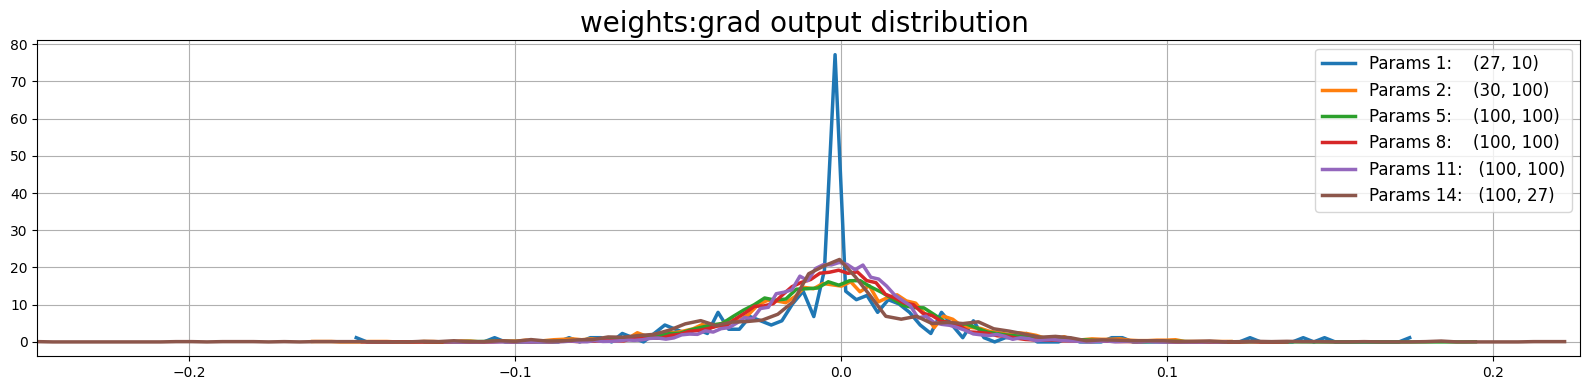

In [111]:
### Visualize the weights:grad ratio
# This grad:data has to be approx equal for all layers 
visualize_statistics(viz_types="weights:grad", only_linear_params=True, num_iterations=1, gain=5/3, final_layer_scale=5/3, use_batch_norm=True, figsize=(16,4), tit_fontsize=20, leg_fontsize=12, tick_fontsize=10)

# This curve shows the gradients for all weights of all linear layers
# We have printed the ratio between the weights and the gradients as strings
# We shall use this plot in order to check the symmetri of the weights:grad for all layers. We don't necessary want a specific ratio, we just want the ratio to be roughly the same for all layers 
# However, these ratios are not as important as the weight:update ratio

##### Visualize the weights:update ratio

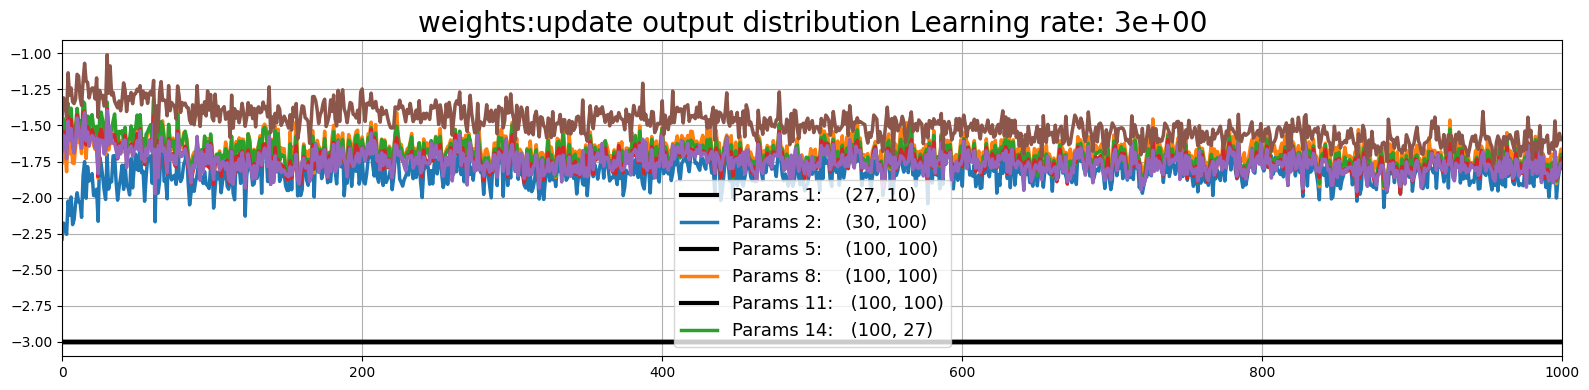

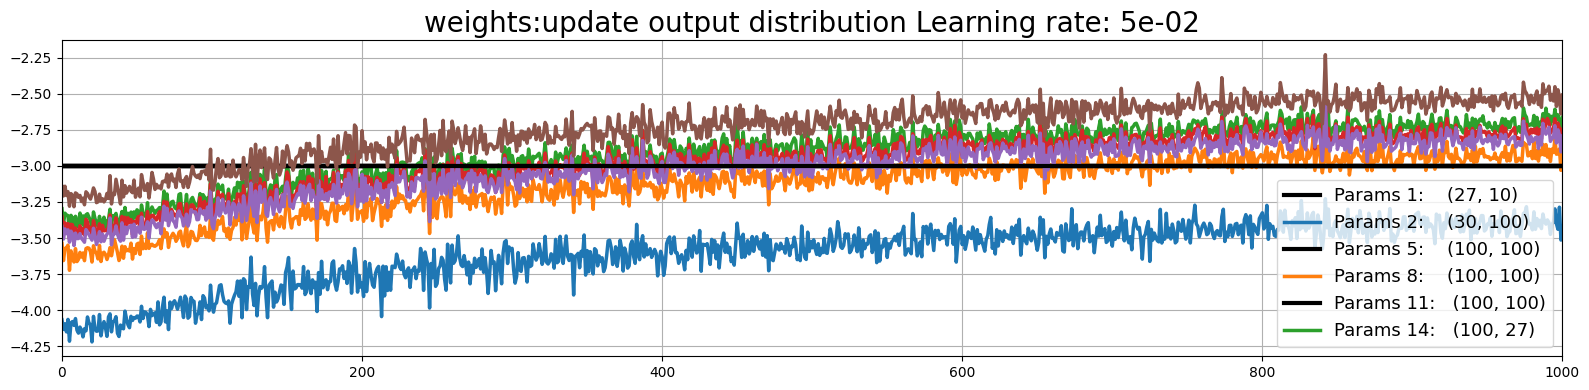

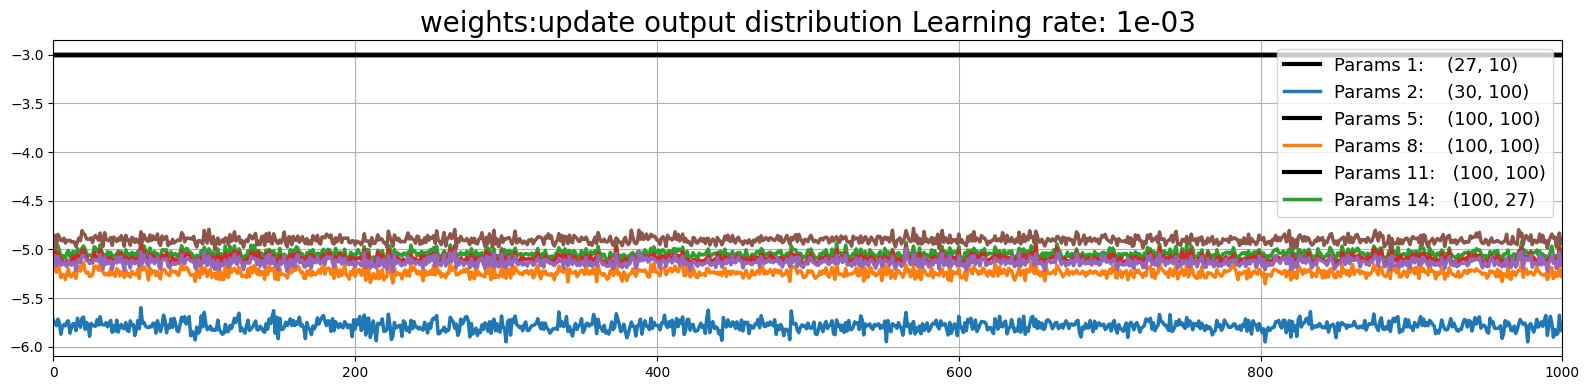

In [116]:
### Visualize the weights:update ratio
# This is basically a measure of how fast the update is running, i.e. the ratio between the size of the parameter weights and the update that these weights are undertaking
# This graph should approximately stay at a point of around 1e-3 for all weights in all layers 
# Hence, this graph can be used to evaluate the learning rate of the training.
    # If the curves are well above the solid, black threshold curve, then the learning rate is too high
    # If the curves are well below the solid, black threshold curve, then the learning rate is too low 
    # If the curves are well around the solid, black threshold curve, then the learning rate is set just right 


for lr_idx, lr in enumerate([3, 5e-2, 1e-3]):
    # if lr_idx==1:
    #     continue 
    visualize_statistics(viz_types="weights:update", num_iterations=1001, lr=lr, title_post_fix=f"Learning rate: {lr:.0e}", use_batch_norm=True, figsize=(16,4), tit_fontsize=20, leg_fontsize=13, tick_fontsize=10)

### BONUS content below, not covered in video

In [ ]:
# BatchNorm forward pass as a widget

from ipywidgets import interact
import scipy.stats as stats
import numpy as np

def normshow(x0):
    """
    Visualizes the effect of batch normalization on input values.

    This function generates a plot to illustrate the impact of batch normalization
    on input values. It uses a slider to adjust the value of the 0th element of
    the input tensor, displaying the transformed distribution, mean, and standard
    deviation after batch normalization.

    The blue curve is the original, input distribution
    The red curve is the output, standard normal distribution 

    The blue dots on top of the plot are the values in the original, input tensor
    The red dots in the bottom of the plot are the normalized outputs after performing batch normalization
    The blue and the red dots are connected, such that we can see how the batch norm will affect each of the values in the input tensor

    Parameters:
        x0 (float): The slider parameters for the value to override the 0th element of the input tensor.

    Returns:
        None
    """

    # Create the (5, ) input tensor and overwrite the first value with the value from the slider and perform a batch normalization to get the y output tensor 
    g = torch.Generator().manual_seed(2147483648)                                   # Create a random generator with a fixed seed for deterministic results
    x = torch.randn(5, generator=g) * 5                                             # Generate a random input tensor of size (5,) and scale it by 5
    x[0] = x0                                                                       # Override the 0th element of x with the value from the slider
    mu = x.mean()                                                                   # Calculate the mean of the input tensor x 
    sig = x.std()                                                                   # Calculate the std of the input tensor x 
    y = (x - mu) / sig                                                              # Perform standardization on the input tensor to get the normalized output y
    
    # Create a new figure for plotting with specified size (10, 5)
    plt.figure(figsize=(10, 5))
    plt.plot([-6, 6], [0, 0], 'k')                                                  # Plot a black horizontal line at y=0
    xx = np.linspace(-6, 6, 100)                                                    # Create an array of x values for plotting the PDF
    plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')                                  # Plot the PDF of the input tensor x with blue color
    plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')                                     # Plot the standard normal distribution PDF with red color
    _ = [plt.plot([x[i], y[i]], [1, 0], 'k', alpha=0.2) for i in range(len(x))]     # Plot little lines connecting each input and output pair
    plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)                      # Plot input values using scatter plots
    plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)                     # Plot output values using scatter plots 
    plt.xlim(-6, 6)                                                                 # Set the limits for the x-axis 
    plt.yticks([])                                                                  # Remove the ticks on the y-axis 

    # Set the title of the plot with input mean and standard deviation
    first_string = f'Input μ: {mu:.2f}, σ: {sig:.2f} from x tensor: [{x0:.3f}, {", ".join(f"{k.item():.3f}" for k in sorted(x[1:]))}]'
    second_string = f'Output μ: {y.data.mean():.2f}, σ: {y.data.std():.2f} from x tensor: [{", ".join(f"{k.item():.3f}" for k in sorted(y.data))}]'
    plt.title(f"{first_string}\n{second_string}")

# Create an interactive widget using the 'interact' function
interact(normshow, x0=(-30, 30, 0.050));


In [ ]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()                                                     # retain_grad() will keep the gradient, even after the loss.backward() that will otherwise compute and then clear the gradients ...
b.retain_grad()                                                     # retain_grad() will keep the gradient, even after the loss.backward() that will otherwise compute and then clear the gradients ...
c.retain_grad()                                                     # retain_grad() will keep the gradient, even after the loss.backward() that will otherwise compute and then clear the gradients ...
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

In [ ]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g)  / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())